In [1]:
# Import data
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
import numba
from numba import jit
from functions import *
import plotly.graph_objects as go
import xgboost as xgb
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Ridge
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.model_selection import cross_val_score
import statsmodels.api as sm 
from IPython.display import display, HTML
import plotly
import tensorflow as tf
import random
import sqlite3
import os
X_used, Y = get_data(42)
n = X_used.shape[0]

grid_size = 50
a_grid = np.linspace(np.min(X_used.age), np.max(X_used.age), grid_size)
w_grid = np.linspace(np.min(X_used.hh_inc), np.max(X_used.hh_inc), grid_size)
xv, wv = np.meshgrid(a_grid, w_grid, indexing='ij')

X_used_cnst = sm.add_constant(X_used)
model = sm.OLS(Y,X_used_cnst)
results = model.fit()
# results.summary()

In [2]:
# Make Database
database_name = 'database_happiness_NP.db'
con = sqlite3.connect(os.path.join('Results', database_name))
cur = con.cursor()

res = cur.execute("""SELECT name FROM sqlite_master WHERE type='table'""")
table_names = res.fetchall()
if ~np.isin('ATE', table_names):
    print("CREATE NEW DATABASE TABLE")
    cur.execute("""CREATE TABLE IF NOT EXISTS ATE(
                Method TEXT NOT NULL,
                Model TEXT NOT NULL,
                Seed INTEGER NOT NULL,
                Param_val TEXT NOT NULL,
                Treatment TEXT NOT NULL,
                Treat_Val REAL NOT NULL,
                PRIMARY KEY (Method, Model, Seed, Treatment))""")
    con.commit()
else:
    print("DATABASE TABLE ALREADY EXISTS")
    con.commit()

if ~np.isin('CATE', table_names):   #create the heterogeneous across income and age variables
    print("CREATE NEW DATABASE TABLE")
    cur.execute("""CREATE TABLE IF NOT EXISTS CATE(
                Method TEXT NOT NULL,
                Model TEXT NOT NULL,
                Seed INTEGER NOT NULL,
                Param_val TEXT NOT NULL,
                Treatment TEXT NOT NULL,
                Conditional TEXT NOT NULL,
                Treat_Val REAL NOT NULL,
                Condi_Val REAL NOT NULL,
                PRIMARY KEY (Method, Model, Seed, Treatment, Conditional, Condi_Val))""")
    con.commit()
else:
    print("DATABASE TABLE ALREADY EXISTS")
    con.commit()

DATABASE TABLE ALREADY EXISTS
DATABASE TABLE ALREADY EXISTS


In [4]:
h = 1  # Bandwidth parameter
weights_w = np.zeros((n, grid_size))
for i in range(grid_size):
    u = np.abs(X_used['hh_inc'].values - w_grid[i])/h
    val = Gaussian(u)
    weights_w[:,i] = val/np.sum(val)

h = 1  # Bandwidth parameter
weights_a = np.zeros((n, grid_size))
for i in range(grid_size):
    u = np.abs(X_used['age'].values - a_grid[i])/h
    val = Gaussian(u)
    weights_a[:,i] = val/np.sum(val)

characteristic_names = ['zerotofive','sixtotwenty','grp','home_own','gender','isHHH',
                        'live_together','college_educ','work','get_social_benefit',
                        'got_social_benefit','religion','marriage','health','health','health',
                        'exercise','exercise','exercise','smoke','alcohol']

ATE_names = ['zerotofive','sixtotwenty','grp','home_own','gender','isHHH',
                        'live_together','college_educ','work','get_social_benefit',
                        'got_social_benefit','religion','marriage','health1','health2','health3',
                        'exercise1','exercise2','exercise3','smoke','alcohol']

positives = [1,1,1,1,1,1,1,1,1,1,1,1,1,5,5,2,3,3,1,1,1]
negatives = [0,0,0,0,0,0,0,0,0,0,0,0,0,1,4,1,0,2,0,0,0]
plot_names = ['Baby - No Baby', 'Teenager - No Teenager', 'Grandparents - No Grandparents','Homeowner - Lease',
              'Female - Male', 'Head - Not Head', 'Live Together - Separate', 'College Education - No College Education',
              'Work - No Work','Receive Social Insurance - Has Never Received', 'Had Received Social Insurance - Has Never Received',
              'Religion - No Religion','Married - Not Married', 'Very Healty (5) - Very Unhealty (1)','Very Healty (5) - Healty (4)',
              'Unhealty (2) - Very Unhealty (1)','Exercise regularly - No Exercise','Exercise regularly - Exercise irregularly',
              'Almost No Exercise - No Exercise', 'Smoke - No Smoke', 'Alcohol - No Alcohol']
seed = 42

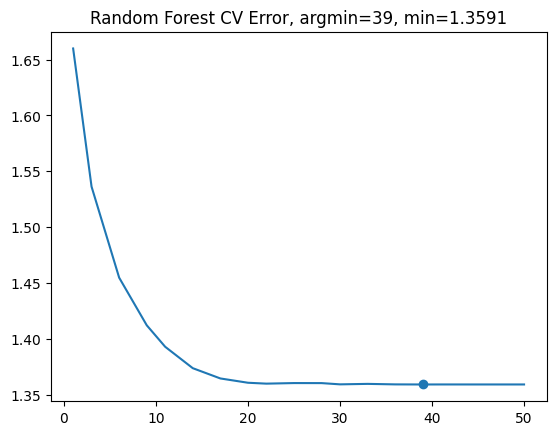

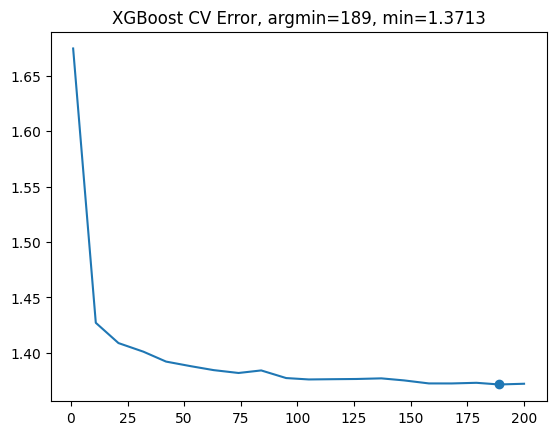

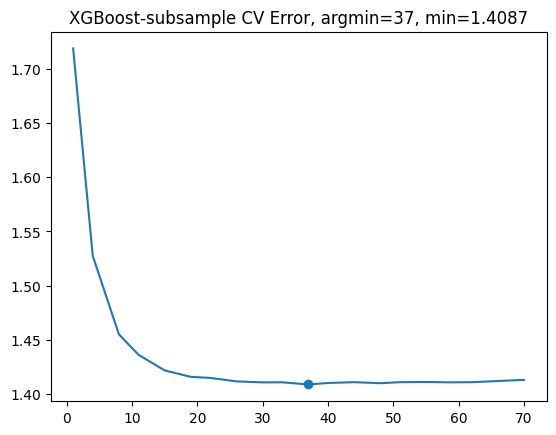

In [5]:
## Import Tuned Parameters
query = "select * from cv_error where seed=%i"%seed
cve_read = pd.read_sql(query,con)

Model_names = np.unique(cve_read.Model)
model_n = Model_names.shape[0]
tuned_params = {}
for i,m in enumerate(Model_names):
    temp = cve_read.loc[cve_read.Model==m]
    idx = temp.Tune_Param=='CV_grid'
    grid = temp[idx].values[0][3:]
    val = temp[~idx].values[0][3:]
    if np.isin('None', grid):
        grid = [None if x=='None' else x for x in grid]
    plt.plot(grid,val)
    plt.scatter(grid[val.argmin()],val[val.argmin()])
    plt.title('%s CV Error, argmin=%i, min=%0.4f'%(m,grid[val.argmin()],val[val.argmin()]))
    plt.show()
    tuned_params[m] = grid[val.argmin()]

In [6]:
t = time.time()
n_estimators = 500
RF_model = RandomForestRegressor(n_estimators=n_estimators, max_depth=int(tuned_params['Random Forest']), random_state=seed)
RF_model.fit(X_used,Y)
elapsed = time.time() - t
print('elapsed time = %0.2f sec; %s'%(elapsed, datetime.datetime.now()))

t = time.time()
XGB_model = xgb.XGBRegressor(n_jobs=1, tree_method="exact", n_estimators=int(tuned_params['XGBoost']),random_state=seed)
XGB_model.fit(X_used,Y)
elapsed = time.time() - t
print('elapsed time = %0.2f sec; %s'%(elapsed, datetime.datetime.now()))

t = time.time()
num_parallel_tree = 100
subsample = np.sqrt(X_used.shape[0])/X_used.shape[0]
XGBs_model = xgb.XGBRegressor(n_jobs=1, tree_method="exact", n_estimators=int(tuned_params['XGBoost-subsample']),
                           num_parallel_tree = num_parallel_tree, subsample = subsample, random_state=seed)
XGBs_model.fit(X_used,Y)
elapsed = time.time() - t
print('elapsed time = %0.2f sec; %s'%(elapsed, datetime.datetime.now()))

elapsed time = 59.03 sec; 2024-08-22 09:57:02.559625
elapsed time = 3.31 sec; 2024-08-22 09:57:05.872805
elapsed time = 38.77 sec; 2024-08-22 09:57:44.645938


In [7]:
t = time.time()
ATE_all = {}
ATE_all['Method'] = ['Nonparametric']*model_n
ATE_all['Model'] = ['RF', 'XGB','XGBs']
ATE_all['Seed'] = [seed]*model_n
ATE_all['Param_val'] = [int(tuned_params['Random Forest']), int(tuned_params['XGBoost']), int(tuned_params['XGBoost-subsample'])]

for j,char_name in enumerate(characteristic_names):
    print(char_name)
    x_fix_1 = X_used.copy()
    x_fix_0 = X_used.copy()
    x_fix_1[char_name] = positives[j]
    x_fix_0[char_name] = negatives[j]
    val_1_RF = np.mean(RF_model.predict(x_fix_1))
    val_0_RF = np.mean(RF_model.predict(x_fix_0))
    val_1_XGB = np.mean(XGB_model.predict(x_fix_1))
    val_0_XGB = np.mean(XGB_model.predict(x_fix_0))
    val_1_XGBs = np.mean(XGB_model.predict(x_fix_1))
    val_0_XGBs = np.mean(XGB_model.predict(x_fix_0))
    ATE_all[ATE_names[j]] = [val_1_RF-val_0_RF, val_1_XGB-val_0_XGB, val_1_XGBs-val_0_XGBs]
elapsed = time.time() - t
print('elapsed time = %0.2f sec; %s'%(elapsed, datetime.datetime.now()))

zerotofive
sixtotwenty
grp
home_own
gender
isHHH
live_together
college_educ
work
get_social_benefit
got_social_benefit
religion
marriage
health
health
health
exercise
exercise
exercise
smoke
alcohol
elapsed time = 79.26 sec; 2024-08-22 06:25:14.993042


In [8]:
ATE_all_pd = pd.DataFrame.from_dict(ATE_all)
ATE_all_pd_melt = pd.melt(ATE_all_pd, id_vars=['Method','Model','Seed','Param_val'], value_vars=ATE_names)
ATE_all_pd_melt = ATE_all_pd_melt[['Method','Model','Seed','Param_val','variable','value']]

In [9]:
out = ATE_all_pd_melt.values
query = ''' insert or replace into ATE (Method,Model,Seed,Param_val,Treatment,Treat_Val) values (?,?,?,?,?,?) '''
cur.executemany(query, out)
con.commit()

In [10]:
CATE_all_w = {}
CATE_all_w['Method'] = ['Nonparametric']*(model_n*grid_size)
CATE_all_w['Model'] = np.repeat(['RF','XGB','XGBs'],grid_size)
CATE_all_w['Seed'] = [seed]*(model_n*grid_size)
CATE_all_w['Param_val'] = np.repeat([int(tuned_params['Random Forest']), int(tuned_params['XGBoost']),int(tuned_params['XGBoost-subsample'])],grid_size)
CATE_all_w['Conditional'] = ['hh_inc']*(model_n*grid_size)
CATE_all_w['Condi_Val'] = w_grid.tolist()*model_n
t = time.time()
for j,char_name in enumerate(characteristic_names):
    print(char_name)
    val_1_RF = np.zeros((grid_size,))
    val_0_RF = np.zeros((grid_size,))
    val_1_XGB = np.zeros((grid_size,))
    val_0_XGB = np.zeros((grid_size,))
    val_1_XGBs = np.zeros((grid_size,))
    val_0_XGBs = np.zeros((grid_size,))
    for i in range(grid_size):
        x_fix_1 = X_used.copy()
        x_fix_0 = X_used.copy()
        x_fix_1['hh_inc'] = w_grid[i]
        x_fix_0['hh_inc'] = w_grid[i]
        x_fix_1[characteristic_names[j]] = positives[j]
        x_fix_0[characteristic_names[j]] = negatives[j]
        val_1_RF[i] = np.sum(weights_w[:,i]*RF_model.predict(x_fix_1))
        val_0_RF[i] = np.sum(weights_w[:,i]*RF_model.predict(x_fix_0))
        val_1_XGB[i] = np.sum(weights_w[:,i]*XGB_model.predict(x_fix_1))
        val_0_XGB[i] = np.sum(weights_w[:,i]*XGB_model.predict(x_fix_0))
        val_1_XGBs[i] = np.sum(weights_w[:,i]*XGBs_model.predict(x_fix_1))
        val_0_XGBs[i] = np.sum(weights_w[:,i]*XGBs_model.predict(x_fix_0))
    CATE_all_w[ATE_names[j]] = np.concatenate((val_1_RF-val_0_RF, val_1_XGB-val_0_XGB, val_1_XGBs-val_0_XGBs))
elapsed = time.time() - t
print('elapsed time = %0.2f sec; %s'%(elapsed, datetime.datetime.now()))

# plt.plot(w_grid, val_rf_w)
# plt.legend(characteristic_names)
# plt.title('Random Forest')
# plt.xlabel('log household income')
# plt.plot(w_grid, np.zeros((grid_size,)),color='black',linestyle='dashed')
# plt.savefig('Figures/RF_all_w.png')

zerotofive
sixtotwenty
grp
home_own
gender
isHHH
live_together
college_educ
work
get_social_benefit
got_social_benefit
religion
marriage
health
health
health
exercise
exercise
exercise
smoke
alcohol
elapsed time = 6824.01 sec; 2024-08-22 08:18:59.047003


In [11]:
CATE_all_w_pd = pd.DataFrame.from_dict(CATE_all_w)
CATE_all_w_pd_melt = pd.melt(CATE_all_w_pd, id_vars=['Method','Model','Seed','Param_val','Conditional','Condi_Val'], value_vars=ATE_names)
CATE_all_w_pd_melt = CATE_all_w_pd_melt[['Method','Model','Seed','Param_val','variable','Conditional','value','Condi_Val']]
CATE_all_w_pd_melt
out = CATE_all_w_pd_melt.values
query = ''' insert or replace into CATE (Method,Model,Seed,Param_val,Treatment,Conditional,Treat_Val,Condi_Val) values (?,?,?,?,?,?,?,?) '''
cur.executemany(query, out)
con.commit()

# # CATE_all_w_pd_pivot = CATE_all_w_pd_melt.pivot(index = ['Model','seed','variable'],columns=['Condi_Val'],values='value')
# # CATE_all_w_pd_pivot

In [7]:
CATE_all_a = {}
CATE_all_a['Method'] = ['Nonparametric']*(model_n*grid_size)
CATE_all_a['Model'] = np.repeat(['RF','XGB','XGBs'],grid_size)
CATE_all_a['Seed'] = [seed]*(model_n*grid_size)
CATE_all_a['Param_val'] = np.repeat([int(tuned_params['Random Forest']), int(tuned_params['XGBoost']),int(tuned_params['XGBoost-subsample'])],grid_size)
CATE_all_a['Conditional'] = ['age']*(model_n*grid_size)
CATE_all_a['Condi_Val'] = a_grid.tolist()*model_n

t = time.time()
for j,char_name in enumerate(characteristic_names):
    print(char_name)
    val_1_RF = np.zeros((grid_size,))
    val_0_RF = np.zeros((grid_size,))
    val_1_XGB = np.zeros((grid_size,))
    val_0_XGB = np.zeros((grid_size,))
    val_1_XGBs = np.zeros((grid_size,))
    val_0_XGBs = np.zeros((grid_size,))
    for i in range(grid_size):
        x_fix_1 = X_used.copy()
        x_fix_0 = X_used.copy()
        x_fix_1['age'] = a_grid[i]
        x_fix_0['age'] = a_grid[i]
        x_fix_1[characteristic_names[j]] = positives[j]
        x_fix_0[characteristic_names[j]] = negatives[j]
        val_1_RF[i] = np.sum(weights_a[:,i]*RF_model.predict(x_fix_1))
        val_0_RF[i] = np.sum(weights_a[:,i]*RF_model.predict(x_fix_0))
        val_1_XGB[i] = np.sum(weights_a[:,i]*XGB_model.predict(x_fix_1))
        val_0_XGB[i] = np.sum(weights_a[:,i]*XGB_model.predict(x_fix_0))
        val_1_XGBs[i] = np.sum(weights_a[:,i]*XGBs_model.predict(x_fix_1))
        val_0_XGBs[i] = np.sum(weights_a[:,i]*XGBs_model.predict(x_fix_0))
    CATE_all_a[ATE_names[j]] = np.concatenate((val_1_RF-val_0_RF, val_1_XGB-val_0_XGB, val_1_XGBs-val_0_XGBs))
elapsed = time.time() - t
print('elapsed time = %0.2f sec; %s'%(elapsed, datetime.datetime.now()))

# plt.plot(w_grid, val_rf_w)
# plt.legend(characteristic_names)
# plt.title('Random Forest')
# plt.xlabel('log household income')
# plt.plot(w_grid, np.zeros((grid_size,)),color='black',linestyle='dashed')
# plt.savefig('Figures/RF_all_w.png')

zerotofive
sixtotwenty
grp
home_own
gender
isHHH
live_together
college_educ
work
get_social_benefit
got_social_benefit
religion
marriage
health
health
health
exercise
exercise
exercise
smoke
alcohol
elapsed time = 7025.64 sec; 2024-08-22 11:54:50.308424


In [8]:
CATE_all_a_pd = pd.DataFrame.from_dict(CATE_all_a)
CATE_all_a_pd_melt = pd.melt(CATE_all_a_pd, id_vars=['Method','Model','Seed','Param_val','Conditional','Condi_Val'], value_vars=ATE_names)
CATE_all_a_pd_melt = CATE_all_a_pd_melt[['Method','Model','Seed','Param_val','variable','Conditional','value','Condi_Val']]
CATE_all_a_pd_melt
out = CATE_all_a_pd_melt.values
query = ''' insert or replace into CATE (Method,Model,Seed,Param_val,Treatment,Conditional,Treat_Val,Condi_Val) values (?,?,?,?,?,?,?,?) '''
cur.executemany(query, out)
con.commit()
cur.close()
con.close()

# CATE_all_a_pd_pivot = CATE_all_a_pd_melt.pivot(index = ['Model','seed','variable'],columns=['Condi_Val'],values='value')
# CATE_all_a_pd_pivot